In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_column', 100)
sns.set()

### Simulation on historical data

Lit's simulate quarter replenishment on the known data. Since the data ends at the middle of September 2025, we will take the last full quarter: from April to June

In [2]:
df = pd.read_parquet("../data/data_month.parquet")

start_date = pd.to_datetime("2025-04-01")
end_date = pd.to_datetime("2025-06-01")

In [3]:
train = df[df["date"] < start_date]
test = df[df["date"].between(start_date, end_date)]

Fit model on train and make predicts with 90% confidence intervals with month granularity

In [4]:
from pipeline import fit_predict
from config import Config

config = Config(frequency="month", predict_folder="../predict", model_name="prophet", data_folder="../data", horizon_days=4*30, heuristics_min_rows=10, ci_levels=(0.6, 0.7, 0.9))

Importing plotly failed. Interactive plots will not work.


In [6]:
predict = fit_predict(config, train, test)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

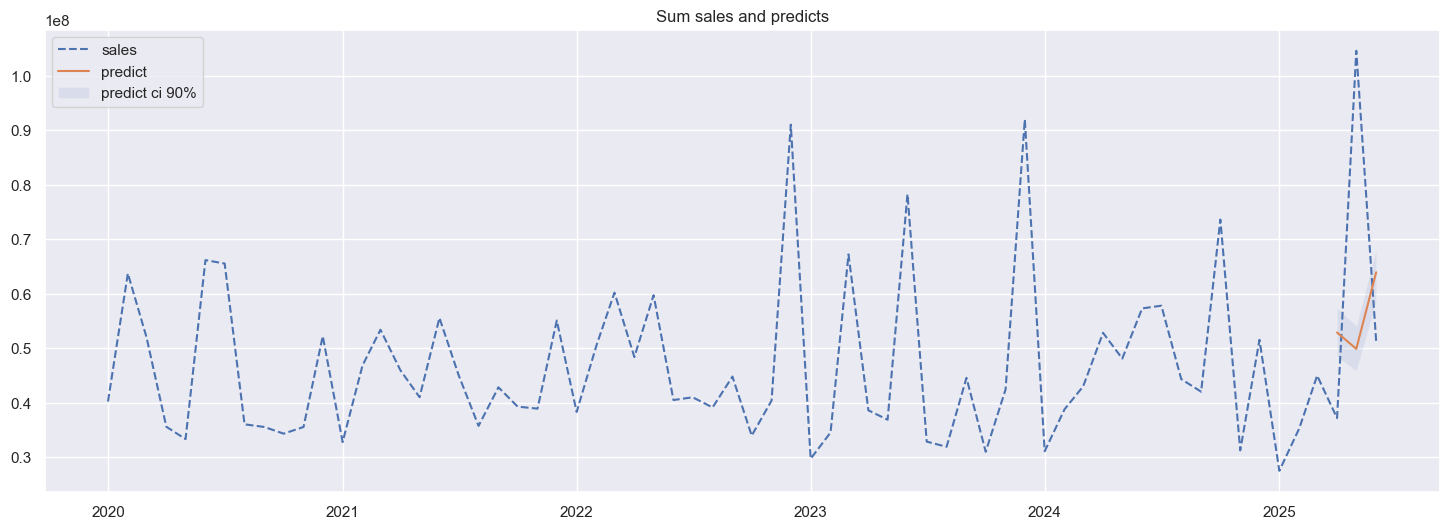

In [10]:
df_plot = df[df["date"] <= end_date].groupby("date")[["sales"]].sum()
prophet_plot = predict.groupby("date")[["predict", 'lower_0.9', 'upper_0.9']].sum()

plt.figure(figsize=(18, 6))
plt.plot(df_plot.index.values, df_plot["sales"].values, linestyle="--", label="sales")
plt.plot(prophet_plot.index.values, prophet_plot["predict"].values, label="predict")
plt.fill_between(prophet_plot.index.values, prophet_plot["lower_0.9"].values, prophet_plot["upper_0.9"].values, label="predict ci 90%", alpha=0.1)
plt.legend()
plt.title("Sum sales and predicts")
plt.show()

### Inventory planned volume

Compute minimum amount of inventory needed for chosen confidence level as a sum of predictions' ci upper bounds for all SKUs

In [14]:
sales_qty_predict = predict["upper_0.9"].sum()
sales_qty_predict

np.float64(179699933.19606993)

### Performance evaluation

Compute real sales on that period

In [15]:
sales_qty = predict["sales"].sum()
sales_qty

np.float64(193017792.587)

In [17]:
sales_qty / sales_qty_predict

np.float64(1.0741116546570946)

It means that 100% of predicted quantity of sales was realy sold and, unfortunately, we have missed sales

Also, determine the month when predicted sales quantity will be sold

In [38]:
df_agg = predict.groupby("date")[["sales", "upper_0.9"]].sum().reset_index()

In [39]:
df_agg

,date,sales,upper_0.9
0,2025-04-01,3.714044e+07,5.738639e+07
1,2025-05-01,1.046153e+08,5.411982e+07
2,2025-06-01,5.126207e+07,6.819372e+07


In [41]:
df_agg["stock"] = 0.
df_agg.loc[0, "stock"] = sales_qty_predict
df_agg["stock"] = (df_agg["stock"] - df_agg["sales"]).cumsum().shift(1).fillna(sales_qty_predict)
df_agg

,date,sales,upper_0.9,stock
0,2025-04-01,3.714044e+07,5.738639e+07,1.796999e+08
1,2025-05-01,1.046153e+08,5.411982e+07,1.425595e+08
2,2025-06-01,5.126207e+07,6.819372e+07,3.794422e+07


In [42]:
df_agg["stock"].iloc[-1] - df_agg["sales"].iloc[-1]

np.float64(-13317859.390930071)

So, we can see that theere will be enough stock for April and May, but somewhere in June we will have out-of-stock situation

Also, let's compute classic sales predict metrics

In [43]:
from model import calc_quality

In [44]:
calc_quality(df_agg, predict_colname="upper_0.9")

,wape,wape_max,bias,hist_bias_-inf_-0.2,hist_bias_-0.2_0.2,hist_bias_0.2_inf
0,45.422267,45.422267,-6.899809,33.333333,0.0,66.666667


From the metrics we can see that accuracy is not so bad, but Bias is negative, it means that the model prone to underpredict

**Conclusion**: while chosen method looks sane and statistically correct, model with poor metrics can cause out-of-stock 

### Predict 

Let's fit the model on all available data, make predict and compute inventory volume estimation with the same methodology that was used before

Since data ends before October, it's enough to make predict on next 3 months: October, November, December

In [47]:
predict_future = fit_predict(config, df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

In [48]:
sales_qty_predict = predict_future["upper_0.9"].sum()
print(sales_qty_predict)

223898072.27625817
